#Functions and script to interface with recorded Harp Binaries#

Where numbered binary files have been saved in Behavior.harp, and SoundCard.harp folders.
We will create a general reader for the harp behavior board binaries and another specifically for register 32 of the sound card.

In [1]:
# Import main libraries and define data folder
import numpy as np
import harp
import pandas as pd
from harp.model import Model, Register, Access
import os
import matplotlib.pyplot as plt

import harp_utils as hu

######################################################################################
animal_ID = 'FNT098'
session_ID = '2024-03-19T13-15-30'

# path behavioural data on ceph repo
input_dir = r"W:\projects\FlexiVexi\behavioural_data" 
output_dir = (r"C:\Users\megan\Documents\sjlab\flexible-navigation-task" +
              r"\Data Analysis\intermediate_variables")

######################################################################################

# Create reader for behavior.
bin_b_path = os.path.join(input_dir, animal_ID, session_ID, "Behavior.harp")
behavior_reader = harp.create_reader(bin_b_path)

# Specify mapping from sound index to reward port
soundIdx0 = 14
soundIdx1 = 10
soundOffIdx = 18

**Get trial start times from dot onset times**

(2850529.109504, 2850549.109504)

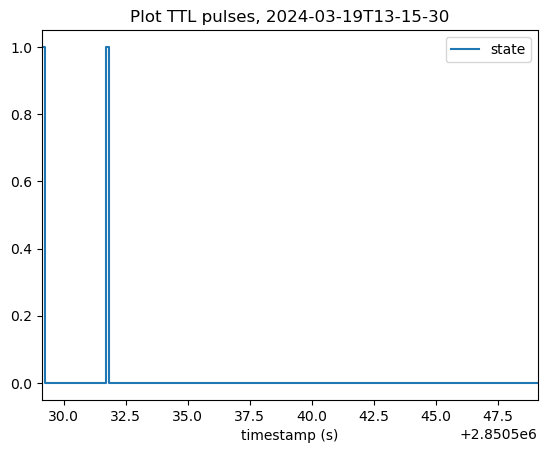

In [2]:
#%matplotlib

# Get data frame with state of TTL pulse
ttl_state_df = hu.get_ttl_state_df(behavior_reader)

# Plot ttl trace
ttl_pulse = hu.get_square_wave(ttl_state_df)
ttl_pulse.plot(x = 'timestamp', y = 'state')
plt.xlabel('timestamp (s)')
plt.legend(loc = 'upper right')
plt.title("Plot TTL pulses, " + session_ID)
t0 = ttl_pulse['timestamp'].iloc[0]
plt.xlim(t0,t0+20)

**Align dot times with experimental-data-csv**

In [3]:
# Import behavioural data as data frame
session_path = os.path.join(input_dir, animal_ID, session_ID)
filepath = os.path.join(session_path, 'Experimental-data', session_ID + '_experimental-data.csv')
df_trials = pd.read_csv(filepath)

# Get dot onset and offset times given by TTL pulses
dot_times_ttl = hu.get_dot_times_from_ttl(ttl_state_df, df_trials['DotOnsetTime'].iloc[0])

# Add dot onset and offset times given by TTL pulses
df_trials = pd.concat([df_trials, dot_times_ttl],axis=1)
df_trials[['TrialStart','DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_ttl', 'DotOffsetTime_ttl']]


,TrialStart,DotOnsetTime,DotOffsetTime,DotOnsetTime_ttl,DotOffsetTime_ttl
0,2.850532e+06,2.850532e+06,2.850587e+06,2.850532e+06,2.850587e+06
1,2.850595e+06,2.850595e+06,2.850646e+06,2.850595e+06,2.850646e+06
2,2.850650e+06,2.850650e+06,2.850720e+06,2.850650e+06,2.850720e+06
3,2.850734e+06,2.850734e+06,2.850744e+06,2.850734e+06,2.850744e+06
4,2.850755e+06,2.850755e+06,2.850768e+06,2.850755e+06,2.850768e+06
...,...,...,...,...,...
101,2.852824e+06,2.852824e+06,2.852844e+06,2.852824e+06,2.852844e+06
102,2.852848e+06,2.852848e+06,2.852873e+06,2.852848e+06,2.852873e+06
103,2.852887e+06,2.852887e+06,2.852944e+06,2.852887e+06,2.852944e+06
104,2.852958e+06,2.852958e+06,2.852972e+06,2.852958e+06,2.852972e+06


**Get all poke events**

In [4]:
# Read the behavior harp stream, Digital Input states for the nosepoke timestamps and IDs. Drop DI3 <-- What's DI3??
all_pokes = behavior_reader.DigitalInputState.read()

all_pokes.drop(columns=['DI3','DIPort2'],inplace = True) # remove all nose pokes to dummy port
#all_pokes.reset_index(inplace=True)

# Show resulting data frame
all_pokes

# Get data frame with first poke in all_pokes within each trial


,DIPort0,DIPort1
Time,,
2.850529e+06,False,False
2.850535e+06,False,True
2.850535e+06,False,False
2.850535e+06,False,True
2.850535e+06,False,False
...,...,...
2.853131e+06,False,False
2.853197e+06,False,False
2.853197e+06,False,False


**Align poke events with trials**

In [5]:
# Flag all trials for which 'TrialCompletionCode' contains the string 'Aborted' or 'DotTimeLimitReached' as aborted
AbortTrial = df_trials['TrialCompletionCode'].str.contains('Aborted|DotTimeLimitReached')
completed_trials = ~AbortTrial

# Pre-index ChoicePort and NosepokeInTime_harp
ChoicePort = np.full(df_trials.shape[0],np.nan)
NosepokeInTime_harp = np.full(df_trials.shape[0],np.nan)

# Get timestamp of first nose poke in response window of non-aborted trials)
for t, row in df_trials.iterrows():

    if completed_trials[t]: # Skip aborted trials
        # Define start of response window as dot offset time
        response_window_start = row['DotOffsetTime_ttl']
        
        # Define trial end as simultaneous with the start of the next trial
        # NOTE: # if last trial, take first response in 10s window after dot offset
        if t == df_trials.shape[0]: 
            trial_end = df_trials.loc[t, 'DotOnsetTime_ttl']+10
        else:
            trial_end = df_trials.loc[t+1, 'DotOnsetTime_ttl'] 

        # Get all pokes in each trial between start of response window and trial end
        trial_pokes = all_pokes[(all_pokes.index >= response_window_start) & (all_pokes.index <= trial_end)]

        if not trial_pokes.empty:
            first_poke = trial_pokes.iloc[0]
            # mark choice port row t with 0 = left, 1 = right)
            ChoicePort[t] = (0 if first_poke['DIPort0'] else 1)
            NosepokeInTime_harp[t] = first_poke.name
        else:
            Warning('No nosepoke detected in trial ' + str(t))
            ChoicePort[t] = np.nan
            NosepokeInTime_harp[t] = np.nan

# Convert numpy arrays to pandas Series
AbortTrial = pd.Series(AbortTrial, name='AbortTrial')
ChoicePort = pd.Series(ChoicePort, name='ChoicePort')
NosepokeInTime_harp = pd.Series(NosepokeInTime_harp, name='NosepokeInTime_harp')

# Append to df_trials
df_trials = pd.concat([df_trials, AbortTrial, ChoicePort, NosepokeInTime_harp], axis=1)

# Check difference between NosepokeInTime and NosepokeInTime_harp
NosepokeInTime_diff = df_trials['NosepokeInTime_harp'] - df_trials['NosepokeInTime']


0      0.0
1      0.0
2      NaN
3      0.0
4      0.0
      ... 
101    0.0
102    NaN
103    NaN
104    NaN
105    NaN
Length: 106, dtype: float64

**Get all audio events**

In [ ]:
# Load the soundcard binary data (register 32) and show resulting dataframe
bin_sound_path = os.path.join(input_dir, animal_ID, session_ID, "SoundCard.harp","SoundCard_32.bin")

# the explicitly defined model will be deprecated or redundant in future
model = Model(device='Soundcard', whoAmI=1280,firmwareVersion='2.2',hardwareTargets='1.1',registers={'PlaySoundOrFrequency': Register(address=32, type="U16", access=Access.Event)})
sound_reader = harp.create_reader(model, keep_type=True)

# Read the harp soundcard stream, for the timestamps and audio ID
all_sounds = sound_reader.PlaySoundOrFrequency.read(bin_sound_path)
all_sounds.reset_index(inplace=True)

# Filter to only keep events (when sound actually happened, not write commands to the board) 
all_sounds = all_sounds.loc[all_sounds['MessageType'] == 'EVENT']

# Show dataframe (maybe)
all_sounds

**Align sound events to trials**

In [ ]:
# Function to extract and parse sounds from binary files from register 32 of harp soundcard (almost the same as extracting pokes)
# Function to parse pokes from behavior trial data using a dataframe containing the timestamps for the start and end of each trial from the experimental csv generated by Bonsai
def parse_trials_sounds(df_events,df_trials,OFF_index=18):

    # Create lists to store the poke IDs and timestamps for all trials
    ON_S, OFF_S, ID_S = [], [], []

    # Iterate through trials (rows) and extract data from harp stream
    for index, trial in df_trials.iterrows():

        # Extract events that occur within the time range of this trial
        trial_events=df_events[(df_events.Time >= trial.TrialStart) & (df_events.Time <= trial.TrialEnd)]

        # Create trial lists for sounds this trial
        ON, OFF, ID = [], [], []
        for _, sound in trial_events.iterrows():
            event_time = sound.Time
            sound = sound[['PlaySoundOrFrequency']]
            sound = int(sound.iloc[0])

            # find audio IDs from the value. Only find ID for OFFSET
            if sound != OFF_index:
                ON.append(event_time)
                ID.append(sound)

            else:
                OFF.append(event_time)

        ON_S.append(ON)
        OFF_S.append(OFF)
        ID_S.append(ID)
    sound_df = pd.DataFrame({'AudioCueStart': ON_S, 'AudioCueEnd': OFF_S, 'AudioCueIdentity': ID_S}) # create dataframe from all nosepoke events

    return sound_df

# Set index of silence (OFF)
sound_df = parse_trials_sounds(all_sounds,df_trials, OFF_index = 18)

# Show dataframe
sound_df

**Get photodiode data**

In [ ]:
# Grab photodiode data
photodiode = behavior_reader.AnalogData.read()
diode = photodiode.AnalogInput0

plt.figure()
# Set the trial number you want to see here
set_trial_number = False
if set_trial_number:
    trial_number = 1
    ist = 1*trial_number
    ie = trial_number+3
else:
    ist = 0
    ie = -1


# Find Timestamps for this trial
t_start = trials_on.index[ist]
t_end = trials_on.index[ie]

# plot the diode trace, draw points at the TTL onsets. Restrict plot to chosen trial (2 seconds either side of TTL)
plt.plot(diode, label = 'Photodiode')
plt.plot(trials_on,'o', label = 'TTL ON')
plt.plot(trials_off,'o', label = 'TTL OFF')
plt.xlim([t_start-2,t_end-2])
plt.xlabel('Time (Harp timestamps)')
plt.ylabel('AU')
plt.legend(loc = 'upper right')
# total_trials = trials_on.shape[0] /3
# print(f'Total trials = {total_trials}')